# Classification

# 1. Loading Library

In [1]:
import pandas as pd
import numpy as np
import time
import os
import getpass

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN

# 2. Loading Data

## 2-1. client data

In [5]:
# 고객 데이터를 불러온다.
df_client = pd.read_csv("./data/01client_demo.csv", encoding="cp949")
df_client.head()

,고객번호,성별,연령대,거주지역
0,1,M,60세이상,60.0
1,2,M,60세이상,100.0
2,3,M,60세이상,33.0
3,4,F,60세이상,16.0
4,5,M,60세이상,100.0


In [6]:
# 서울시 데이터만 선별하기 위해 우편 데이터를 가져온다.
comuser = getpass.getuser()
path = f'C:\\Users\\{comuser}\\Desktop\\ModuleProject01\data\post_num'

file_list = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.xlsx' in file:
            file_list.append(os.path.join(r, file))

In [7]:
# 파일명을 가진 변수로 데이터프레임을 생성한다.
for file in file_list :
    save_file = file.split('\\')[-1].split('.')[0]
    globals()[save_file] = pd.read_excel(file.replace('\\', '\\\\'))

In [8]:
서울시.head()

,우편번호\n(구역번호),시도,시군구,읍면,도로명주소,범위종류
0,6267,서울특별시,강남구,NaN,강남대로 238 ~ 246,짝수
1,6266,서울특별시,강남구,NaN,강남대로 248 ~ 256,짝수
2,6265,서울특별시,강남구,NaN,강남대로 262 ~ 276,짝수
3,6258,서울특별시,강남구,NaN,강남대로 278 ~ 292,짝수
4,6253,서울특별시,강남구,NaN,강남대로 298 ~ 318,짝수


In [8]:
def s_cut_postnum(df):
    df['CutPostnum'] = df['우편번호\n(구역번호)'].apply(lambda x: str(x)[0:2])

In [9]:
s_cut_postnum(서울시)
서울시.head()

,우편번호\n(구역번호),시도,시군구,읍면,도로명주소,범위종류,CutPostnum
0,6267,서울특별시,강남구,NaN,강남대로 238 ~ 246,짝수,62
1,6266,서울특별시,강남구,NaN,강남대로 248 ~ 256,짝수,62
2,6265,서울특별시,강남구,NaN,강남대로 262 ~ 276,짝수,62
3,6258,서울특별시,강남구,NaN,강남대로 278 ~ 292,짝수,62
4,6253,서울특별시,강남구,NaN,강남대로 298 ~ 318,짝수,62


In [10]:
s_postnum = 서울시['CutPostnum']
s_koo = 서울시['시군구']

frame = { '거주지역': s_postnum, 'S_koo': s_koo } 

df_post_s = pd.DataFrame(frame)
df_post_s.head()

,거주지역,S_koo
0,62,강남구
1,62,강남구
2,62,강남구
3,62,강남구
4,62,강남구


In [11]:
df_post_s['거주지역'] = df_post_s['거주지역'].apply(lambda x : np.float64(x))
df_post_s = df_post_s.drop_duplicates()
s_df_client = df_client[df_client['거주지역']<100]
s_df_client.head()

,고객번호,성별,연령대,거주지역
0,1,M,60세이상,60.0
2,3,M,60세이상,33.0
3,4,F,60세이상,16.0
6,7,F,60세이상,36.0
7,8,M,60세이상,10.0


In [12]:
s_df_client = pd.merge(s_df_client, df_post_s, how='left')
s_df_client.head()

,고객번호,성별,연령대,거주지역,S_koo
0,1,M,60세이상,60.0,강남구
1,3,M,60세이상,33.0,은평구
2,4,F,60세이상,16.0,노원구
3,7,F,60세이상,36.0,서대문구
4,8,M,60세이상,10.0,강북구


In [13]:
len(s_df_client)

5841

## 2-2. purchase data

### 해당 데이터 크기가 커서 서울시 데이터로 불러와서 분석할 것!

In [14]:
# 고객 구매내역 불러오기 ... 시간이 오래걸려서 확인
start = time.time()

df_purchase = pd.read_csv('./data/02purchaseTR.csv', encoding='CP949')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 17.574827671051025


In [15]:
df_purchase.head()

,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,고객번호,점포코드,구매일자,구매시간,구매금액
0,B,8664000,15,1504,B150401,17218,44,20140222,20,2420
1,B,8664000,16,1601,B160101,17218,44,20140222,20,1070
2,B,8664000,16,1602,B160201,17218,44,20140222,20,8060
3,B,8664000,18,1803,B180301,17218,44,20140222,20,6000
4,B,8664001,5,509,B050901,17674,44,20140222,22,1120


In [16]:
# 데이터 크기가 크기 때문에 sample 수 확인
df_purchase.shape

(28593030, 10)

In [17]:
# 서울시 고객 데이터의 구매내역만 불러온다.
s_df_purchase = pd.merge(s_df_client, df_purchase, how='left')
#s_df_purchase.drop(['성별', '연령대', '거주지역', 'S_koo'], axis='columns', inplace=True)
s_df_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800


In [18]:
s_df_purchase.shape

(8181992, 14)

In [19]:
# 구매내역 데이터 파일 크기가 크기 때문에 서울시 구매내역으로 데이터를 대체하여 새로 저장한다.
s_df_purchase.to_csv('./data/02_s_purchaseTR.csv', index=False)

In [66]:
# 서울시 고객의 구매내역 데이터 불러오기
s_df_purchase = pd.read_csv('./data/02_s_purchaseTR.csv')
s_df_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800


## 2-3. product data

In [21]:
# 상품정보 불러오기
df_product =  pd.read_csv('./data/03product.csv', encoding='CP949')
df_product.head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
0,A,1,101,A010101,일용잡화,위생세제
1,A,1,101,A010102,일용잡화,휴지류
2,A,1,101,A010103,일용잡화,뷰티상품
3,A,1,101,A010104,일용잡화,일용잡화
4,A,1,101,A010105,일용잡화,세트상품


## 2-4. channel data

In [22]:
# 채널정보 불러오기
df_channel = pd.read_csv("./data/06channel.csv", encoding="cp949")
df_channel.head()

,고객번호,제휴사,이용횟수
0,7,A_MOBILE/APP,4
1,14,A_MOBILE/APP,1
2,42,B_MOBILE/APP,23
3,74,A_MOBILE/APP,1
4,74,B_MOBILE/APP,30


In [23]:
df_channel.isnull().sum()

고객번호    0
제휴사     0
이용횟수    0
dtype: int64

In [24]:
# 서울시 고객의 채널 데이터 변경
s_df_channel = pd.merge(s_df_client, df_channel, how='left')
s_df_channel.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,이용횟수
0,1,M,60세이상,60.0,강남구,NaN,NaN
1,3,M,60세이상,33.0,은평구,NaN,NaN
2,4,F,60세이상,16.0,노원구,NaN,NaN
3,7,F,60세이상,36.0,서대문구,A_MOBILE/APP,4.0
4,8,M,60세이상,10.0,강북구,NaN,NaN


# 3. EDA(Exploratory Data Analysis)

## 3-0. target

In [25]:
# 고객별 1년간 구매금액 및 구매금액구간을 구한다.
custTotal = s_df_purchase.groupby(s_df_purchase['고객번호']).sum().iloc[:,-2:]

custTotal['구매금액_1년'] = custTotal['구매금액'] // 2

bins = np.linspace(custTotal['구매금액_1년'].min(), custTotal['구매금액_1년'].max(), 20)
custTotal['구매금액구간'] = np.digitize(custTotal['구매금액_1년'], bins)

custTotal = custTotal.iloc[:,-3:]

custTotal.head()

,구매금액,구매금액_1년,구매금액구간
고객번호,,,
1,85042550,42521275,1
3,3165167,1582583,1
4,16693810,8346905,1
7,73726276,36863138,1
8,62355952,31177976,1


In [26]:
custTotal['구매금액구간'].value_counts()

1     5491
2      277
3       44
4       14
6        4
7        2
10       2
5        2
8        2
17       1
9        1
20       1
Name: 구매금액구간, dtype: int64

In [27]:
len(custTotal)

5841

(array([5.768e+03, 5.800e+01, 6.000e+00, 4.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

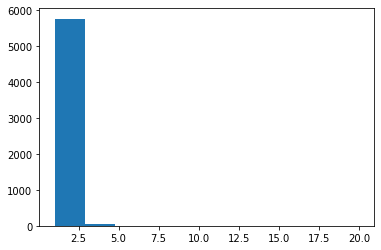

In [28]:
plt.hist(custTotal['구매금액구간'])

In [ ]:
# 서울시 고객 전체에서 분포가 좌편향인 것을 확인할 수 있어서 적당한 기준을 통해 target을 설정한다.

In [29]:
custTotal['VIP'] = 0

In [30]:
# VIP 기준으로 고객을 구분짓는다(롯데백화점 400만원 + 롯데마트 600만원 + 롯데슈퍼 240만원 = 1240만원)
custTotal.loc[custTotal['구매금액_1년']>=12400000, 'VIP']=1
custTotal.loc[custTotal['구매금액_1년']<12400000, 'VIP']=0

In [31]:
custTotal.head()

,구매금액,구매금액_1년,구매금액구간,VIP
고객번호,,,,
1,85042550,42521275,1,1
3,3165167,1582583,1,0
4,16693810,8346905,1,0
7,73726276,36863138,1,1
8,62355952,31177976,1,1


In [32]:
custTotal['VIP'].value_counts()

0    3191
1    2650
Name: VIP, dtype: int64

(array([3191.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2650.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

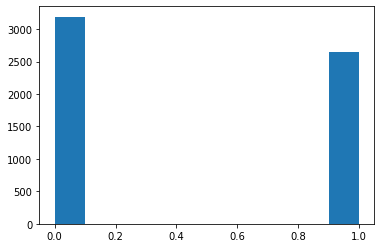

In [33]:
plt.hist(custTotal['VIP'])

## 3-1. client data

In [34]:
s_df_client.head()

,고객번호,성별,연령대,거주지역,S_koo
0,1,M,60세이상,60.0,강남구
1,3,M,60세이상,33.0,은평구
2,4,F,60세이상,16.0,노원구
3,7,F,60세이상,36.0,서대문구
4,8,M,60세이상,10.0,강북구


### 성별

In [35]:
s_df_client['성별'].value_counts()

F    4854
M     987
Name: 성별, dtype: int64

In [36]:
# F(여성) = 1, M(남성) = 0
for data in enumerate(s_df_client['성별'].unique()):
    s_df_client['성별'].replace(data[1], data[0], inplace=True)

In [37]:
s_df_client['성별'].value_counts()

1    4854
0     987
Name: 성별, dtype: int64

In [ ]:
# crosstab

### 연령

In [38]:
s_df_client['연령대'].value_counts()

45세~49세    1215
40세~44세     998
50세~54세     965
35세~39세     685
55세~59세     637
60세이상       618
30세~34세     438
25세~29세     205
20세~24세      76
19세이하         4
Name: 연령대, dtype: int64

In [39]:
#60세이상 : 6.0
#55~59세 : 5.5
#50~54세 : 5.0
#45~49세 : 4.5
#40~44세 : 4.0
#35~39세 : 3.5
#30~34세 : 3.0
#25~29세 : 2.5
#20~24세 : 2.0
#19세이하 : 1.0

In [40]:
# 이 부분을 포문 돌리려다 빡쳐서 걍 ..이렇게햇어
# 숫자 는 20세~24세를 20으로 할지 2024로 할지 고민하다가 걍 일단 네자리로 하고  19세이하랑 60세 이상도
# 네자리 맞추려고 저렇게 했엉
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("60세이상", "6.0")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("55세~59세", "5.5")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("50세~54세", "5.0")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("45세~49세", "4.5")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("40세~44세", "4.0")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("35세~39세", "3.5")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("30세~34세", "3.0")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("25세~29세", "2.5")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("20세~24세", "2.0")
s_df_client_koo["연령대"] = s_df_client_koo["연령대"].replace("19세이하", "1.0")
s_df_client_koo["연령대"]

NameError: name 's_df_client_koo' is not defined

(array([ 618.,  637.,  965., 1215.,  998.,  685.,  438.,  205.,   76.,
           4.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

C:\ai\python\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ai\python\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ai\python\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ai\python\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ai\python\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ai\python\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51060 missing from current font.
 

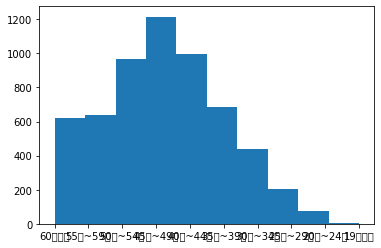

In [41]:
plt.hist(s_df_client['연령대'])

In [ ]:
# crosstab

### 거주지역

In [42]:
s_df_client['거주지역'].value_counts()

55.0    1431
16.0     819
60.0     603
24.0     339
49.0     329
47.0     278
13.0     220
10.0     185
75.0     175
27.0     146
36.0     139
39.0     119
65.0     114
72.0     109
43.0     109
33.0      96
87.0      95
69.0      94
52.0      88
20.0      76
82.0      68
30.0      66
45.0      54
79.0      48
85.0      41
Name: 거주지역, dtype: int64

## 3-2. purchase data

In [76]:
s_df_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800


In [149]:
custVIP = custTotal.reset_index()
custVIP.drop(['구매금액', '구매금액_1년'], axis='columns', inplace=True)
s_df_purchase_vip = pd.merge(s_df_purchase, custVIP, how='left')
s_df_purchase_vip.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000,1,1
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000,1,1
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000,1,1
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650,1,1
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800,1,1


### 제휴사

In [151]:
s_df_purchase_vip['구매금액'].groupby(s_df_purchase_vip['제휴사']).describe()

,count,mean,std,min,25%,50%,75%,max
제휴사,,,,,,,,
A,2275481.0,84155.929529,429816.276303,10.0,6500.0,14500.0,49000.0,93654000.0
B,3345302.0,9053.366342,129504.170345,10.0,2380.0,4280.0,7980.0,48112000.0
C,2513395.0,5210.101344,61413.931026,10.0,1490.0,2960.0,5000.0,23976000.0
D,47814.0,8428.949555,12872.029077,100.0,1600.0,3600.0,9900.0,291000.0


In [152]:
s_df_purchase_vip[s_df_purchase['구매금액']==93654000.0]

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
4026114,7801,M,40세~44세,69.0,동작구,A,5526155,1,109,A010901,1,20151120,13,93654000,7,1


In [153]:
s_df_purchase_vip[s_df_purchase['구매금액']==87769260.0]

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
5931538,13376,F,25세~29세,16.0,노원구,A,4593637,8,801,A080110,1,20150627,16,87769260,10,1


In [154]:
s_df_purchase_vip[s_df_purchase_vip['고객번호']==7801][s_df_purchase_vip['구매금액']==120]

C:\ai\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
4026220,7801,M,40세~44세,69.0,동작구,A,2012213,1,109,A010904,1,20140525,20,120,7,1


In [155]:
s_df_purchase_vip['구매금액'][s_df_purchase_vip['고객번호']==7801].describe()

count    6.320000e+02
mean     1.160122e+06
std      4.546237e+06
min      1.200000e+02
25%      3.000000e+04
50%      1.995000e+05
75%      1.000000e+06
max      9.365400e+07
Name: 구매금액, dtype: float64

In [156]:
df_product[df_product['소분류코드']=='A010901']

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
120,A,1,109,A010901,주류,주류


In [157]:
df_product[df_product['소분류코드']=='A010904']

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
123,A,1,109,A010904,주류,공병


In [158]:
pd.crosstab(s_df_purchase_vip['제휴사'], s_df_purchase_vip['VIP'])

VIP,0,1
제휴사,,
A,614956,1660525
B,2213904,1131398
C,1932208,581187
D,41174,6640


In [ ]:
# vip 고객 비중이 압도적으로 A 제휴사가 높은 것을 확인할 수 있다.

### 영수증번호

In [159]:
print(s_df_purchase_vip['구매금액'].groupby(s_df_purchase_vip['영수증번호']).mean().max())
print(s_df_purchase_vip['구매금액'].groupby(s_df_purchase_vip['영수증번호']).mean().min())

93654000.0
10.0


In [160]:
totalBill = s_df_purchase_vip.groupby(s_df_purchase_vip['영수증번호']).sum().reset_index()
totalBill['영수증총액'] = totalBill['구매금액']

In [161]:
totalBill = totalBill[['영수증번호', '영수증총액']]

In [162]:
totalBill.head()

,영수증번호,영수증총액
0,1,5950
1,2,1490
2,3,3980
3,4,10090
4,5,65620


In [164]:
s_df_purchase_vip = pd.merge(s_df_purchase_vip, totalBill, how='left')
s_df_purchase_vip.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP,영수증총액
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000,1,1,10000
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000,1,1,129000
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000,1,1,58450
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650,1,1,58450
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800,1,1,58450


In [165]:
s_df_purchase_vip['영수증총액'].describe()

count    8.181992e+06
mean     5.760913e+04
std      2.569510e+05
min      1.000000e+01
25%      1.185000e+04
50%      2.696000e+04
75%      5.800000e+04
max      9.365400e+07
Name: 영수증총액, dtype: float64

In [166]:
s_df_purchase_vip['영수증총액'].groupby(s_df_purchase_vip['VIP']).describe()

,count,mean,std,min,25%,50%,75%,max
VIP,,,,,,,,
0,4802242.0,32554.234408,45185.366734,10.0,9910.0,20640.0,40860.00,7422500.0
1,3379750.0,93209.296590,393415.649288,20.0,17950.0,41580.0,87878.75,93654000.0


In [ ]:
# vip 고객의 구매건수보다 vip 아닌 고객의 구매건수가 많지만, vip고객은  평균값이 더 크고 편차가 더 크게 나타난 것을 알 수 있다.

### 분류코드

In [167]:
s_df_purchase_vip['대분류코드'].value_counts()

1     1735969
3      550197
15     436565
4      394677
5      386259
       ...   
42        205
41        122
85         85
40         45
39         16
Name: 대분류코드, Length: 92, dtype: int64

In [168]:
s_df_purchase_vip['중분류코드'].value_counts()

106     520069
104     340010
101     223533
402     221041
102     183020
         ...  
4003         1
5101         1
4211         1
4208         1
511          1
Name: 중분류코드, Length: 640, dtype: int64

In [169]:
s_df_purchase_vip['소분류코드'].value_counts()

A010302    93145
A010401    88626
A010403    80483
A010404    73123
A010402    69855
           ...  
A040305        1
B270103        1
A040201        1
B090201        1
B410604        1
Name: 소분류코드, Length: 4137, dtype: int64

In [ ]:
# 상품의 총 개수는 4137개로 각각 640개의 중분류와 92개의 대분류로 나누어진다.

In [179]:
pd.crosstab(s_df_purchase_vip['대분류코드'], s_df_purchase_vip['VIP']).sort_values([1], ascending=[False]).head()

VIP,0,1
대분류코드,,
1,650117,1085852
4,147395,247282
2,71826,179622
3,372148,178049
5,235213,151046


In [176]:
pd.crosstab(s_df_purchase_vip['중분류코드'], s_df_purchase_vip['VIP']).sort_values([1], ascending=[False]).head()

VIP,0,1
중분류코드,,
106,165936,354133
104,101544,238466
402,62393,158648
101,126938,96595
102,92124,90896


In [177]:
pd.crosstab(s_df_purchase_vip['소분류코드'], s_df_purchase_vip['VIP']).sort_values([1], ascending=[False]).head()

VIP,0,1
소분류코드,,
A010401,25287,63339
A010302,32538,60607
A010403,24669,55814
A010404,22224,50899
A010402,19338,50517


In [178]:
df_product[df_product['대분류코드']==1].head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
0,A,1,101,A010101,일용잡화,위생세제
1,A,1,101,A010102,일용잡화,휴지류
2,A,1,101,A010103,일용잡화,뷰티상품
3,A,1,101,A010104,일용잡화,일용잡화
4,A,1,101,A010105,일용잡화,세트상품


In [180]:
df_product[df_product['중분류코드']==106].head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
53,A,1,106,A010601,가공식품,한식델리
54,A,1,106,A010602,가공식품,일식델리
55,A,1,106,A010603,가공식품,서양델리
56,A,1,106,A010604,가공식품,에스닉푸드
57,A,1,106,A010605,가공식품,중식델리


In [181]:
df_product[df_product['소분류코드']=='A010401'].head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
19,A,1,104,A010401,농산물,청과


### 점포코드

In [187]:
s_df_purchase_vip['점포코드'][s_df_purchase_vip['VIP']==1].value_counts().head()

2     493867
7     432055
20    322905
12    261461
1     245750
Name: 점포코드, dtype: int64

In [189]:
s_df_purchase_vip['S_koo'][s_df_purchase_vip['점포코드']==2].value_counts().head()

송파구    469264
강남구     45506
광진구     31431
강동구     15396
성동구     11155
Name: S_koo, dtype: int64

In [190]:
s_df_purchase_vip['S_koo'][s_df_purchase_vip['점포코드']==7].value_counts().head()

송파구    635914
강남구     36334
강동구     18213
광진구     15621
성동구      8106
Name: S_koo, dtype: int64

In [ ]:
# VIP고객이 대체로 송파구, 강남구 근처에 있는 점포에 있는 것을 확인할 수 있다.

### 구매일자

In [197]:
s_df_purchase['구매일자'].describe()

count    8.181992e+06
mean     2.014582e+07
std      4.999929e+03
min      2.014010e+07
25%      2.014071e+07
50%      2.015011e+07
75%      2.015070e+07
max      2.015123e+07
Name: 구매일자, dtype: float64

In [200]:
s_df_purchase['구매일자']

0          20140118
1          20140203
2          20140425
3          20140425
4          20140425
             ...   
8181987    20150925
8181988    20150925
8181989    20150925
8181990    20150925
8181991    20150925
Name: 구매일자, Length: 8181992, dtype: int64

(array([3756815.,  208248.,       0.,       0.,       0.,       0.,
              0.,       0.,  197353., 4019576.]),
 array([20140101., 20141214., 20142327., 20143440., 20144553., 20145666.,
        20146779., 20147892., 20149005., 20150118., 20151231.]),
 <a list of 10 Patch objects>)

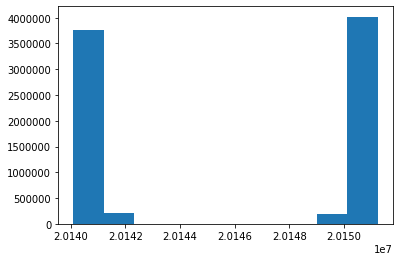

In [198]:
plt.hist(s_df_purchase['구매일자'].sort_values())

### 구매시간

In [199]:
s_df_purchase['구매시간'].value_counts().head()

18    886515
17    875135
16    810246
19    779266
15    728724
Name: 구매시간, dtype: int64

(array([1.515000e+03, 1.150000e+02, 1.190000e+02, 2.695800e+04,
        6.436770e+05, 1.098510e+06, 2.190259e+06, 1.761650e+06,
        1.364804e+06, 1.094385e+06]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

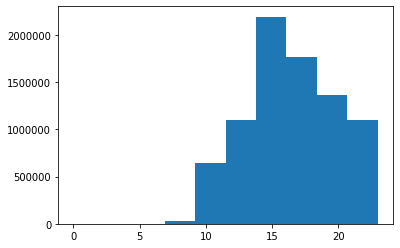

In [194]:
plt.hist(s_df_purchase['구매시간'])

In [ ]:
# 여러가지 데이터를 보고 인터넷을 통해 알 수 있는 사실은
# A(롯데백화점), B(롯데마트), C(롯데슈퍼), D(LOHBs)
# 근거 : 영수증 별 가격 분포 / 점포수 / 취급물품

## 3-3. product data

In [ ]:
df_product.head()

In [ ]:
frame = { '제휴사': df_product['제휴사'], '중분류명': df_product['중분류명'], '소분류명':df_product['소분류명'] } 

df_product_name = pd.DataFrame(frame)

In [ ]:
df_product_name.groupby(df_product_name['제휴사']).describe()

## 3-4. channel data

In [0]:
s_df_channel[s_df_channel['고객번호'].duplicated()]

In [0]:
df_channel.shape

In [0]:
s_df_channel.isnull().sum()

In [0]:
# 전체 데이터 8824개 중 4042의 서울시 고객만이 모바일이나 웹페이지를 이용하지 않은 것을 확인할 수 있다.
# 총 5841명 중 대다수가 이용하지 않는다는 사실을 알 수 있다.

# 혁진아! null값 지우즈아!!

In [30]:
s_df_channel

,고객번호,성별,연령대,거주지역,S_koo,제휴사,이용횟수
0,1,M,60세이상,60.0,강남구,NaN,NaN
1,3,M,60세이상,33.0,은평구,NaN,NaN
2,4,F,60세이상,16.0,노원구,NaN,NaN
3,7,F,60세이상,36.0,서대문구,A_MOBILE/APP,4.0
4,8,M,60세이상,10.0,강북구,NaN,NaN
...,...,...,...,...,...,...,...
6485,19371,F,50세~54세,52.0,강동구,NaN,NaN
6486,19375,F,25세~29세,49.0,광진구,NaN,NaN
6487,19376,M,20세~24세,24.0,동대문구,B_MOBILE/APP,1.0
6488,19379,F,20세~24세,69.0,동작구,NaN,NaN


In [31]:
cust_num =s_df_channel['고객번호']
null_partner = s_df_channel['제휴사']
null_used = s_df_channel['이용횟수']

frame = { '고객번호': cust_num, '제휴사': null_partner, '이용횟수': null_used } 

null_channel = pd.DataFrame(frame)
null_channel

,고객번호,제휴사,이용횟수
0,1,NaN,NaN
1,3,NaN,NaN
2,4,NaN,NaN
3,7,A_MOBILE/APP,4.0
4,8,NaN,NaN
...,...,...,...
6485,19371,NaN,NaN
6486,19375,NaN,NaN
6487,19376,B_MOBILE/APP,1.0
6488,19379,NaN,NaN


In [32]:
null_channel['제휴사'].fillna(0, inplace=True)
null_channel['이용횟수'].fillna(0, inplace=True)
null_channel

,고객번호,제휴사,이용횟수
0,1,0,0.0
1,3,0,0.0
2,4,0,0.0
3,7,A_MOBILE/APP,4.0
4,8,0,0.0
...,...,...,...
6485,19371,0,0.0
6486,19375,0,0.0
6487,19376,B_MOBILE/APP,1.0
6488,19379,0,0.0


In [33]:
null_channel['제휴사'].value_counts()

0               4042
B_MOBILE/APP    1295
A_MOBILE/APP     491
B_ONLINEMALL     395
C_ONLINEMALL     157
D_MOBILE/APP     101
C_MOBILE/APP       9
Name: 제휴사, dtype: int64

In [34]:
type(null_channel['제휴사'][0])

int

# 4. Data Preprocessing

# 4-1. Clustering
* 고객의 구매 내역 데이터에서 (구매빈도, 구매시간, 구매금액) 기준으로 clustering 진행
* KMeans, 계층적군집분석, DBSCAN 시도
* KMeans cluster 데이터 분포가 적절하여 해당 방식 이용

In [35]:
# 구매빈도
df_stuff_cnt = df_purchase['소분류코드'].groupby(df_purchase['소분류코드']).count()
# 구매시간
df_stuff_time = df_purchase['구매시간'].groupby(df_purchase['소분류코드']).mean()
# 구매금액
df_stuff_amt = df_purchase['구매금액'].groupby(df_purchase['소분류코드']).mean()

frame1 = { '구매빈도': df_stuff_cnt, '구매시간': df_stuff_time, '구매금액':df_stuff_amt } 

df_stuff = pd.DataFrame(frame1)
df_stuff.head()

,구매빈도,구매시간,구매금액
소분류코드,,,
A010101,101454,15.540748,11597.932166
A010102,720,15.752778,4777.805556
A010103,46517,15.547434,30730.050949
A010104,25080,15.496252,6138.696970
A010105,484,15.254132,220207.851240


### KMeans

In [36]:
feature = df_stuff[ ['구매빈도', '구매시간', '구매금액']]

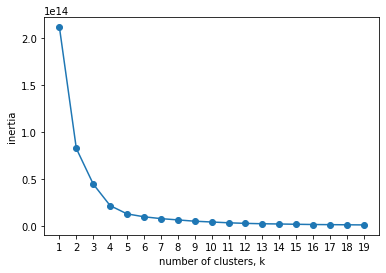

In [37]:
# 적절한 cluster 수 확인 (but 편차때문에 강제로 늘려버림 5 -> 10개)
ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(feature)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [38]:
# 정규표준화, KMeans, 파이프라인 선언
scaler = StandardScaler()
model = KMeans(n_clusters=10)
pipeline = make_pipeline(scaler,model)

In [39]:
# 파이프라인을 이용하여 정규표준화 한 뒤 KMeans 학습
pipeline.fit(feature)
predict = pd.DataFrame(pipeline.predict(feature))
predict.columns=['predict']

In [40]:
# clustring 결과의 분포가 적절히 이루어진 것을 확인할 수 있다.
predict['predict'].value_counts()

1    1839
9    1266
0     657
4     264
5     127
6     125
2      47
8      34
3      22
7       5
Name: predict, dtype: int64

In [41]:
# clustring 데이터와 결과값 데이터를 합침
predict = predict.set_index(feature.index)
r = pd.concat([feature,predict],axis=1)
r.head()

,구매빈도,구매시간,구매금액,predict
소분류코드,,,,
A010101,101454,15.540748,11597.932166,2
A010102,720,15.752778,4777.805556,0
A010103,46517,15.547434,30730.050949,4
A010104,25080,15.496252,6138.696970,0
A010105,484,15.254132,220207.851240,0


In [42]:
# KMeans 결과값 저장
r.to_csv('./data/r_KMeans.csv')

# 4-2. 

In [43]:
product_code = df_purchase['소분류코드']
customer_no = df_purchase['고객번호']

frame2 = { '소분류코드': product_code, '고객번호': customer_no} 

pur_product = pd.DataFrame(frame2)
pur_product.head()

,소분류코드,고객번호
0,B150401,17218
1,B160101,17218
2,B160201,17218
3,B180301,17218
4,B050901,17674


In [44]:
# 구매데이터의 소분류코드, 고객번호와 제품데이터의 clustring 결과값을 merge
pur_prod = pd.merge(pur_product, r['predict'].reset_index(), how='left')
pur_prod.head()

,소분류코드,고객번호,predict
0,B150401,17218,4
1,B160101,17218,4
2,B160201,17218,2
3,B180301,17218,1
4,B050901,17674,4


In [45]:
# cluster에 대한 가변수 생성
cluster_dumm = pd.get_dummies(pur_prod['predict'], prefix='cluster')
cluster_dumm.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [46]:
purchase_product = pd.concat([pur_prod,cluster_dumm],axis=1)
purchase_product = pd.concat([purchase_product['고객번호'], purchase_product.iloc[:,3:]], axis=1)
purchase_product.head()

,고객번호,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,17218,0,0,0,0,1,0,0,0,0,0
1,17218,0,0,0,0,1,0,0,0,0,0
2,17218,0,0,1,0,0,0,0,0,0,0
3,17218,0,1,0,0,0,0,0,0,0,0
4,17674,0,0,0,0,1,0,0,0,0,0


In [47]:
# 고객별 제품cluster 구매 횟수
customer_product_cluster = purchase_product.groupby(purchase_product['고객번호']).sum()
customer_product_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
고객번호,,,,,,,,,,
1,256.0,40.0,351.0,5.0,341.0,0.0,44.0,0.0,0.0,20.0
2,294.0,28.0,553.0,4.0,186.0,0.0,41.0,0.0,0.0,10.0
3,3.0,174.0,729.0,0.0,232.0,0.0,0.0,0.0,0.0,53.0
4,211.0,127.0,252.0,0.0,286.0,0.0,13.0,0.0,0.0,41.0
5,130.0,4.0,464.0,0.0,112.0,0.0,3.0,0.0,0.0,6.0


In [48]:
# 고객별 제품cluster csv파일로 저장
customer_product_cluster.to_csv('./data/cust_KMeans.csv')